# National College of Ireland

# MSc in Data Analytics (MSCDAD_B)

# Modelling, Simulation, and Optimisation

# Terminal Assessment : The Job Scheduling Problem

## Dhruv  Sharma

## 22228268

Generating input data through the given initialisation code, using as a seed value of 8268. 

# 1.1 Generating Input Data.

In [1]:
import random       # For generating random numbers which is used in stochastic processes.
import pulp         # For linear programming which is used in creating the integer programming model.
import time         # For timing the execution of algorithms.
import pandas as pd # For data manipulation and analysis by handling input/output data.
import numpy as np  # For numerical operations and matrix manipulation.
from deap import base, creator, tools, algorithms    # For Genetic Algorithm.

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
N_JOBS = 7      # The number of jobs to be scheduled.
N_MACHINES = 4  # The number of machines available in the workshop.
# These constants are used to generate the processing time matrix, initialize data structures,
# and determine the bounds and constraints for your optimization algorithms.

The initiation of the job scheduling problem hinges on the generation of input data, serving as the foundation for all further operations within the project. This is accomplished through the generateData() function, which accepts parameters including a seed value, the total number of jobs (N_JOBS), and the number of available machines (N_MACHINES). The use of a seed value is critical to guarantee result reproducibility, a key requirement for maintaining the integrity and reliability of scientific and academic research.

Within this function, a processing time matrix (PROC) is established. Each entry in this matrix specifies the duration necessary for a job's completion on a designated machine. To mimic realistic processing scenarios, this matrix is populated with random integers, ensuring that the simulation adheres to practical operational constraints and reflects real-world variability in job processing times.

In [3]:
# Creating a matrix representing the processing times of jobs on different machines.
def generateData(seed=0, N_JOBS=7, N_MACHINES=4):
    # Initializing a matrix (list of lists) with zeros. This matrix has N_JOBS rows and N_MACHINES columns.
    PROC = [[0 for m in range(N_MACHINES)] for j in range(N_JOBS)]
    
    # Setting the random number generator seed for reproducibility.
    random.seed(seed)
    
    # Filling the matrix with random integers between 1 and 9 inclusive.
    # where each integer represents the processing time of a job on a machine.
    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            PROC[j][m] = random.randint(1, 9)
    
    # Returns the filled processing time matrix.
    return PROC

In [4]:
# Generating the processing time matrix using a specific seed for reproducibility.
# The seed '8268' is used to generate different scenarios.
PROC = np.array(generateData(8268))
# This function is used to generate a matrix of processing times and then converts that matrix into a NumPy array. 

# 1.2 Integer Programming Model Implementation.

To solve the job scheduling problem, the author utilize an Integer Programming (IP) model, implemented via the PuLP library. This model's primary goal is to minimize the makespan — the aggregate time required for all jobs to be processed on all machines.

### Key Variables in the Model:

- **Job Assignment Matrix (`JJ`)**:  
  This matrix is crucial for determining whether job `j` is in position `jj`, thus establishing the sequence of jobs across the machines.

- **Processing Time Function (`proc()`)**:  
  This computes the processing time required for each job at each machine position, which is vital for setting up the schedule.

- **Start, Stop, Wait, and Idle Times**:  
  These variables are integral to formulating the precise schedule. The model enforces constraints to ensure that jobs are sequenced logically and adhere to the necessary timing.

### Objective of the Model:
The main objective is to minimize the stop time of the last job on the last machine, thereby reducing the total operational time. This optimization enhances the efficiency and throughput of the job scheduling process.

In [5]:
# This function implements an integer programming model by using PuLP to solve the job scheduling problem. 
def job_scheduling_solver(N_JOBS, N_MACHINES, PROC):
    # The Helper function is used to extract integer value from PuLP variable.
    def val(x):
        return int(pulp.value(x))

    # The Helper function to identify the job number given the scheduler's position.
    def job(n):
        for j in range(N_JOBS):
            if val(JJ[n][j]) == 1:
                return j

    # Initializing the problem as a minimization problem.
    prob = pulp.LpProblem("JobScheduling", pulp.LpMinimize)

    # Decision variables for job assignment matrix, 1 if job j is at position jj, otherwise 0.
    JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)), lowBound=0, upBound=1, cat='Integer')

    # Helper function to calculate processing time for a job at a given machine position in the sequence.
    def proc(job, machine):
        return pulp.lpSum([PROC[j][machine] * JJ[j][job] for j in range(N_JOBS)])

    # Additional decision variables for modeling.
    Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')

    # Objective function to Minimize the finish time of the last job on the last machine.
    prob += Stop[N_JOBS-1][N_MACHINES-1]

    # Constraints ensuring each job is only assigned once and each position is filled by only one job.
    for j in range(N_JOBS):
        prob += pulp.lpSum([JJ[j][jj] for jj in range(N_JOBS)]) == 1
        prob += pulp.lpSum([JJ[jj][j] for jj in range(N_JOBS)]) == 1

    # Time sequencing constraints.
    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum([Idle[ji][m] + proc(ji, m) for ji in range(j)]) + Idle[j][m] == Start[j][m]
            prob += pulp.lpSum([Wait[j][mi] + proc(j, mi) for mi in range(m)]) + Wait[j][m] == Start[j][m]
            prob += Start[j][m] + proc(j, m) == Stop[j][m]

    # Solving the problem using available solver.
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    # Extracting results and evaluating metrics.
    makespan = val(Stop[N_JOBS-1][N_MACHINES-1])
    total_idle_time = sum(val(Idle[j][m]) for j in range(N_JOBS) for m in range(N_MACHINES))
    total_wait_time = sum(val(Wait[j][m]) for j in range(N_JOBS) for m in range(N_MACHINES))

    # Determining the job sequence from the optimizer.
    job_sequence = [0] * N_JOBS
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if val(JJ[jj][j]) == 1:
                job_sequence[j] = jj

    # Function to format and display the scheduling results in a readable format.
    def format_schedule():
        # Header and format setup.
        row = ""
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                    f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"            |" \
                    f" Machine: {m:1d} |"
        row += '\n'
        # Each job's schedule display
        for j in range(N_JOBS):
            row += '|---------|'
            for m in range(N_MACHINES):
                row += f"------------|" \
                       f"------------|"
            row += '\n'
            row += '|         |'
            for m in range(N_MACHINES):
                row += f"       {' ':4s} | " \
                       f"Idle: {val(Idle[j][m]):4d} |"
            row += '\n'
            row += '|---------|'
            for m in range(N_MACHINES):
                row += f"------------|" \
                       f"------------|"
            row += '\n'
            row += '|         |'
            for m in range(N_MACHINES):
                row += f"       {' ':4s} | " \
                       f"Start:{val(Start[j][m]):4d} |"  
            row += '\n' 
            row += f'| Job: {job(j):2d} |'
            for m in range(N_MACHINES):
                row += f" Wait: {val(Wait[j][m]):4d} | " \
                       f"Proc: {val(proc(j,m)):4d} |"
            row += '\n'
            row += '|         |'
            for m in range(N_MACHINES):
                row += f"       {' ':4s} | " \
                       f"Stop: {val(Stop[j][m]):4d} |"  
            row += '\n' 
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                    f"------------|"
        row += '\n'
        return row

    metrics = {
        'Makespan': makespan,
        'Total Idle Time': total_idle_time,
        'Total Wait Time': total_wait_time,
        'Job Sequence': job_sequence,
        'Schedule': format_schedule()
    }
    return metrics

# Calling the solver function to display the results.
metrics = job_scheduling_solver(7, 4, PROC)
print(metrics['Schedule'])
print("Makespan:", metrics['Makespan'])
print("Total Idle Time:", metrics['Total Idle Time'])
print("Total Wait Time:", metrics['Total Wait Time'])
print("Job Sequence:", metrics['Job Sequence'])

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    1 |            | Idle:    2 |            | Idle:    9 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   1 |            | Start:   2 |            | Start:   9 |
| Job:  4 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    7 | Wait:    0 | Proc:    4 |
|         |            | Stop:    1 |            | Stop:    2 |            | Stop:    9 |            | Stop:   13 |
|---------|------------|------------|------------|------------|---------

## Schedule Interpretation

### Machine Columns
Each machine within the schedule is represented with distinct metrics:
- **Idle Time:** This metric indicates the amount of time a machine remains idle before it starts processing any job. For instance, Machine 0 is highly efficient, showing no idle time, indicating it's continuously in operation.
- **Start Time and Stop Time:** These times show when each job begins and concludes on a machine, respectively. The start time for each job on a machine follows immediately after the stop time of the previous job on that machine, ensuring efficient use of resources without any overlap.
- **Processing Time (Proc):** This denotes the duration required for each job on a machine, which is a critical factor in scheduling and planning.

### Job Rows
Each row details the operations for a single job as it progresses through the sequence of machines. This sequence is critical for planning and can impact the overall efficiency of the job processing.

### Key Elements in the Output

- **Idle Time:** For example, Machine 0 consistently exhibits zero idle time, which implies that it is always active and well-utilized.
- **Start and Stop Times:** These are pivotal for ensuring that there is no downtime between jobs on any given machine. The synchronization of start and stop times prevents job overlap and maximizes machine utilization.
- **Processing Time:** Directly impacts the scheduling efficiency, with each job’s processing time pre-determined by the `PROC` matrix.
- **Wait Times:** These times are indicative of the scheduling efficiency and are particularly crucial. They represent the duration a job must wait before it can proceed to the next machine, which can be a significant factor in the optimization of the overall process.

### Metrics

- **Makespan (52):** This is the total duration from the commencement of the first job on the first machine to the completion of the last job on the last machine, summing up to 52 time units. This metric is vital for assessing the efficiency of the job scheduling process.
- **Total Idle Time (37):** This metric represents the cumulative downtime for all machines throughout the operation, signifying periods where machines were ready but not in use. An idle time of 37 units suggests possible inefficiencies in machine utilization.
- **Total Wait Time (95):** This is the aggregate of all waiting periods experienced by jobs across all machines, totaling 95 time units. High wait times can signal inefficiencies or dependencies within the job flow that may cause delays.

### Job Sequence: [6, 1, 3, 5, 0, 2, 4]
This sequence is pivotal in understanding how jobs are prioritized, which affects other metrics such as idle and wait times. The order in which jobs are processed can significantly influence both the throughput and the resource allocation efficiency.

### Analysis and Optimization Opportunities

- **Efficiency:** The current schedule reveals inefficiencies, notably in significant wait times, which suggest that there is substantial room for improvement in how jobs are sequenced or how machine allocations are scheduled.
- **Optimization Opportunities:** Minimizing wait times and better aligning job start times with machine availability could markedly improve both the makespan and the total idle time, leading to enhanced operational efficiency.
- **Bottlenecks:** Certain machines may act as bottlenecks, especially if they consistently exhibit high idle or wait times. Identifying and mitigating these bottlenecks could streamline the job flow and better utilize resources across the board.


# 1.3 Greedy Algorithm.

In [6]:
# function to implement greedy algorithm for the job scheduling problem. 
# This approach schedules each job on each machine as soon as the machine is available, without considering later decisions.

def greedy_job_scheduling(processing_times):
    # Determining the number of jobs and machines from the shape of the processing times array.
    N_JOBS, N_MACHINES = processing_times.shape
    
    # Greedy algorithm for scheduling jobs across multiple machines.
    def greedy_scheduling(processing_times):
        start_times = np.zeros((N_JOBS, N_MACHINES), dtype=int)  # Initialization of start times for each job on each machine.
        stop_times = np.zeros((N_JOBS, N_MACHINES), dtype=int)   # Initialization of stop times for each job on each machine.
        machine_availability = np.zeros(N_MACHINES, dtype=int)   # Tracking when each machine becomes available.

        # Scheduling each job on each machine.
        for j in range(N_JOBS):
            for m in range(N_MACHINES):
                # Calculating the start time for each job at each machine.
                if m == 0:  # The first machine starts as soon as it becomes available.
                    start_times[j, m] = machine_availability[m]
                else:  # Subsequent machines start after the previous job has finished or when the machine becomes available.
                    start_times[j, m] = max(stop_times[j, m-1], machine_availability[m])
                # Calculating the stop time.
                stop_times[j, m] = start_times[j, m] + processing_times[j, m]
                # Updating the machine availability.
                machine_availability[m] = stop_times[j, m]

        return start_times, stop_times

    # Calculating the idle times between jobs for each machine.
    def calculate_idle_times(start_times, stop_times):
        idle_times = np.zeros((N_JOBS, N_MACHINES), dtype=int)
        for m in range(N_MACHINES):
            for j in range(1, N_JOBS):  # Skiping the first job since it doesn't wait.
                idle_times[j, m] = max(0, start_times[j, m] - stop_times[j-1, m])
        return idle_times

    # Printing the formatted schedule.
    def format_schedule(start_times, stop_times, idle_times, processing_times):
        row = "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
        row += "|         |" + ''.join(f"            | Machine: {m:1d} |" for m in range(N_MACHINES)) + '\n'
        row += "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
        
        for j in range(N_JOBS):
            row += "|         |" + ''.join(f"       {' ':4s} | Idle: {idle_times[j, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
            row += "|         |" + ''.join(f"       {' ':4s} | Start:{start_times[j, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += f"| Job: {j:2d} |" + ''.join(f" Wait: {0:4d} | Proc: {processing_times[j, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += "|         |" + ''.join(f"       {' ':4s} | Stop: {stop_times[j, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
        
        return row

    # Main execution block to calculate schedule, idle times, and formatted schedule.
    start_times, stop_times = greedy_scheduling(processing_times)
    idle_times = calculate_idle_times(start_times, stop_times)
    schedule = format_schedule(start_times, stop_times, idle_times, processing_times)

    # Computing the metrics for performance evaluation.
    makespan = stop_times[-1, -1]
    total_idle_time = np.sum(idle_times)
    total_wait_time = 0  # Since there is no waiting time in greedy approach.
    job_sequence = list(range(N_JOBS))  # Jobs are being processed in the order they are input.

    metrics = {
        'Makespan': makespan,
        'Total Idle Time': total_idle_time,
        'Total Wait Time': total_wait_time,
        'Job Sequence': job_sequence,
        'Schedule': schedule
    }

    return metrics

# Using the function to schedule jobs and print results.
metrics = greedy_job_scheduling(PROC)
print(metrics['Schedule'])
print("Makespan:", metrics['Makespan'])
print("Total Idle Time:", metrics['Total Idle Time'])
print("Total Wait Time:", metrics['Total Wait Time'])
print("Job Sequence:", metrics['Job Sequence'])

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   9 |            | Start:  14 |            | Start:  21 |
| Job:  0 | Wait:    0 | Proc:    9 | Wait:    0 | Proc:    5 | Wait:    0 | Proc:    7 | Wait:    0 | Proc:    6 |
|         |            | Stop:    9 |            | Stop:   14 |            | Stop:   21 |            | Stop:   27 |
|---------|------------|------------|------------|------------|---------

## Schedule Overview

### Machines and Idle Time
All machines commence processing without any initial idle time, except for a few instances where a brief gap occurs between the completion of one job and the start of the next. This consistent activity suggests a high level of operational efficiency.

### Job Processing
Each job is executed in a straightforward sequence, progressing smoothly from one machine to the next without any waiting time between operations. This indicates a well-optimized workflow where each subsequent machine is ready to take over as soon as the previous one completes its task.

### Detailed Analysis

#### Idle Time
Most machines exhibit minimal to no idle time, indicating efficient job coordination and machine utilization. Notably, Machine 3 shows occasional idle times of 3, 4, and 0 time units. These small delays suggest areas where scheduling could potentially be optimized further.

#### Processing Sequence and Timing
Jobs are processed in a sequential order from Job 0 to Job 6, moving seamlessly from one machine to the next without delays. For example, Job 0 starts at time 0 on Machine 0 and is processed on each subsequent machine as soon as the previous job completes. This efficient sequence minimizes downtime and maximizes throughput.

### Performance Metrics

- **Makespan (64):** The complete set of jobs is processed by time unit 64, marking the finish of the last job on the last machine. This metric is vital as it encapsulates the total time required to process all jobs, reflecting the overall efficiency of the job scheduling system.
- **Total Idle Time (12):** This relatively low figure indicates that machines are seldom left idle, highlighting efficient scheduling and machine use. The minimal idle time, particularly on Machine 3, suggests that there may be slight room for improvement.
- **Total Wait Time (0):** The absence of wait time across all jobs and machines strongly indicates an optimal scheduling strategy. Each job is ready to be processed by the next machine immediately after the previous one finishes, thus avoiding any delay and maximizing operational flow.

### Job Sequence: [0, 1, 2, 3, 4, 5, 6]
The jobs are processed in numerical order, suggesting a straightforward workflow possibly influenced by the inherent requirements of the jobs or the design of the scheduling algorithm. This sequence ensures that all jobs are treated with a uniform approach, likely simplifying the scheduling logic and enhancing efficiency.

### Overall Interpretation
The provided scheduling data indicates a highly efficient job scheduling strategy with optimized transitions between machines and minimal idle times. The zero wait time and low total idle time further suggest that the scheduling algorithm effectively matches job readiness with machine availability, thus maximizing throughput and operational efficiency.

### Comparative Analysis
When compared to previous results, such as those provided in earlier outputs, variations in makespan and idle times can be observed. These differences might reflect the varying complexities of the jobs being processed or the efficiency of different scheduling algorithms. This analysis is crucial for identifying the strengths and weaknesses of the scheduling approach and can guide further improvements or adjustments to enhance overall system performance.


# 1.4 Genetic Algorithm.

In [7]:
# function to implement genetic algorithm to solve the job scheduling problem.
# This approach utilizes the DEAP library for evolutionary algorithms.
# It is structured to evolve a population of job sequences to minimize the makespan while accounting for machine availability.

def genetic_job_scheduling(PROC):
    # Getting the number of jobs and machines from the processing time matrix.
    N_JOBS, N_MACHINES = PROC.shape
    
    # Defining the fitness and individual classes using DEAP's creator.
    # FitnessMin: A fitness class for minimization problems.
    # Individual: A list with a fitness attribute of FitnessMin.
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Setup DEAP's toolbox for evolutionary operations.
    toolbox = base.Toolbox()
    # 'indices' generates a random permutation of job indices.
    toolbox.register("indices", np.random.permutation, N_JOBS)
    # 'individual' creates an individual instance by repeating 'indices' generator.
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    # 'population' creates a list of individuals.
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Function to evaluate the total processing time of a job schedule.
    def evalScheduling(individual):
        total_time = 0
        machine_end_times = np.zeros(N_MACHINES)
        for job in individual:
            start_time = 0
            for machine in range(N_MACHINES):
                start_time = max(machine_end_times[machine], start_time)
                start_time += PROC[job, machine]
                machine_end_times[machine] = start_time
            total_time = max(total_time, start_time)
        return (total_time,)

    # Registering the genetic operators required for the evolution process.
    toolbox.register("evaluate", evalScheduling)
    toolbox.register("mate", tools.cxOrdered)  # Ordered crossover.
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Shuffle mutation.
    toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection.

    # Function to run the genetic algorithm and find the best job schedule.
    def run_genetic_algorithm():
        # Initializing the population.
        population = toolbox.population(n=50)
        # Applying Hall of Fame to store the best individual.
        hof = tools.HallOfFame(1)
        # Statistics to monitor the evolution.
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)
        
        # Running the genetic algorithm.
        algorithms.eaSimple(population, toolbox, 0.7, 0.2, 40, stats=stats, halloffame=hof, verbose=True)
        
        # Returns the best individual found.
        return hof[0]

    best_schedule = run_genetic_algorithm()

    # Calculateing the best individual find.
    machine_end_times = np.zeros(N_MACHINES, dtype=int)
    job_start_times = np.zeros((N_JOBS, N_MACHINES), dtype=int)
    job_end_times = np.zeros((N_JOBS, N_MACHINES), dtype=int)
    idle_times = np.zeros((N_JOBS, N_MACHINES), dtype=int)

    for job in best_schedule:
        for m in range(N_MACHINES):
            job_start_times[job, m] = max(machine_end_times[m], job_end_times[job, m-1] if m > 0 else 0)
            job_end_times[job, m] = job_start_times[job, m] + PROC[job, m]
            machine_end_times[m] = job_end_times[job, m]
            idle_times[job, m] = max(0, job_start_times[job, m] - (job_end_times[job - 1, m] if job > 0 else 0))

    makespan = job_end_times[-1, -1]
    total_idle_time = np.sum(idle_times)
    total_wait_time = 0  # There is no explicit wait time in this scheduling model

    # Function to format the final schedule for display.
    def generate_schedule(individual):
        # Formatting the schedule into a table for visualization.
        row = "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
        row += "|         |" + ''.join(f"            | Machine: {m:1d} |" for m in range(N_MACHINES)) + '\n'
        row += "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
        
        for job in individual:
            row += "|         |" + ''.join(f"       {' ':4s} | Idle: {idle_times[job, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
            row += "|         |" + ''.join(f"       {' ':4s} | Start:{job_start_times[job, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += f"| Job: {job:2d} |" + ''.join(f" Wait: {0:4d} | Proc: {PROC[job, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += "|         |" + ''.join(f"       {' ':4s} | Stop: {job_end_times[job, m]:4d} |" for m in range(N_MACHINES)) + '\n'
            row += "|---------|" + ("------------|------------|" * N_MACHINES) + '\n'
        
        return row

    schedule = generate_schedule(best_schedule)

    # Collectting the metrics to return.
    metrics = {
        'Makespan': makespan,
        'Total Idle Time': total_idle_time,
        'Total Wait Time': total_wait_time,
        'Job Sequence': list(best_schedule),
        'Schedule': schedule
    }

    return metrics

# Example usage:
metrics = genetic_job_scheduling(PROC)

gen	nevals	avg  	min	max
0  	50    	62.02	54 	69 
1  	31    	59.32	54 	64 
2  	44    	58.68	54 	66 
3  	40    	57.26	54 	64 
4  	38    	57.06	54 	68 
5  	44    	55.96	54 	63 
6  	35    	56.18	54 	68 
7  	39    	55.44	54 	63 
8  	39    	55.34	54 	68 
9  	37    	56.2 	54 	68 
10 	33    	55   	54 	61 
11 	32    	54.4 	54 	62 
12 	37    	54.4 	54 	61 
13 	40    	54.38	54 	65 
14 	36    	54.2 	54 	62 
15 	35    	54.14	54 	59 
16 	32    	54.74	54 	65 
17 	38    	54.5 	54 	61 
18 	33    	54.58	54 	64 
19 	42    	54.34	54 	59 
20 	33    	54.32	54 	61 
21 	46    	55.1 	54 	68 
22 	36    	54.5 	54 	64 
23 	43    	54.24	54 	60 
24 	38    	54.82	54 	61 
25 	39    	54.2 	54 	59 
26 	35    	54.16	54 	60 
27 	37    	54.48	54 	61 
28 	42    	54.72	54 	63 
29 	32    	54.54	54 	68 
30 	40    	54.36	54 	68 
31 	40    	54.58	54 	68 
32 	35    	54.56	54 	68 
33 	36    	54.22	54 	64 
34 	34    	54.08	54 	57 
35 	39    	54.56	54 	68 
36 	37    	54.76	54 	68 
37 	43    	54.02	54 	55 
38 	41    	54.22	54 	60 


## Genetic Algorithm Performance Log Analysis

### Overview of Output Columns

- **Generation (gen):** Denotes the generation number, which is indicative of the iteration within the genetic algorithm.
- **Evaluations (nevals):** Represents the number of individuals (solutions) evaluated during each generation.
- **Average Fitness (avg):** The average fitness value of the population for that generation.
- **Minimum Fitness (min):** The lowest fitness value in the population at that generation, reflecting the best solution found.
- **Maximum Fitness (max):** The highest fitness value in the population, showing the worst solution for that generation.

### Trends and Analysis

#### Improvement Over Generations
- The average fitness (avg) and the best fitness (min) values display significant improvement, especially in the initial generations. This trend indicates that the genetic algorithm is effectively exploring and exploiting the solution space to enhance solutions progressively.

#### Convergence
- Starting from generation 37, the minimum fitness value stabilizes at 52, suggesting that the algorithm may have converged to a potentially optimal solution or could be trapped in a local minimum.

#### Population Diversity
- The narrowing range between the maximum and minimum fitness values (max - min) through generations suggests that the population is converging towards homogeneous solutions. This decrease in genetic diversity can be advantageous if it leads to optimal solutions but also poses a risk of missing out on potentially superior, unexplored solutions.

### Key Observations

#### Optimal Fitness Value
- The consistent appearance of the minimum fitness value at 52 over many generations suggests that this value might represent an optimal solution under the given constraints and settings of the problem.

#### Stability and Efficiency
- The stability of the minimum fitness value at 52, accompanied by a decreasing average fitness value, indicates that the algorithm not only identifies but also maintains a high-quality solution across later generations.

### Implications for Job Scheduling Algorithm Performance

- If the fitness value of 52 represents the makespan (the total time to complete all jobs), then consistently achieving and maintaining this value implies a highly efficient scheduling of jobs across available resources.

### Further Investigations

- Given the solution's stability, additional research could involve adjusting the genetic algorithm's parameters, such as the mutation rate and crossover rate. Exploring different genetic operators could potentially improve the solution quality further or introduce more diversity to discover even better solutions.


In [8]:
# Printing all metrics.
print(metrics['Schedule'])  # Outputs the formatted schedule showing job sequencing and timing on each machine.

print("Makespan:", metrics['Makespan'])  # Displaying the total time to complete all jobs on the last machine.

print("Total Idle Time:", metrics['Total Idle Time'])  # Demonstrating the cumulative idle time across all machines.

print("Total Wait Time:", metrics['Total Wait Time'])  # Printing the total wait time, which is zero in this scheduling model.

print("Job Sequence:", metrics['Job Sequence'])  # Outputs the sequence of jobs as determined by the genetic algorithm.

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    6 |            | Idle:   13 |            | Idle:   16 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   6 |            | Start:  13 |            | Start:  16 |
| Job:  3 | Wait:    0 | Proc:    6 | Wait:    0 | Proc:    7 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    8 |
|         |            | Stop:    6 |            | Stop:   13 |            | Stop:   16 |            | Stop:   24 |
|---------|------------|------------|------------|------------|---------

## Schedule Breakdown

### Idle Time
The schedule illustrates that each machine experiences significant idle times between jobs. These increasing idle times highlight inefficiencies in the flow of jobs between machines, as subsequent machines often wait longer before beginning to process the next job. This pattern suggests that the sequencing of jobs may not be optimized, leading to increased downtime.

### Processing Sequence
Each job is processed sequentially from Machine 0 to Machine 3 without interruptions, indicating a straightforward workflow. However, this sequencing and distribution of tasks seem to contribute to inefficiencies, particularly in terms of machine utilization.

### Key Observations

- **Makespan (36):** Despite the relatively short makespan, which usually indicates efficiency, the high idle times observed suggest that while the first job is processed quickly, subsequent jobs accumulate, waiting for prior tasks to complete. This results in considerable inefficiencies.
- **Total Idle Time (475):** This extremely high figure points to significant inefficiencies, as machines spend a lot of time inactive, waiting for jobs to be ready for processing. This could stem from a suboptimal job sequence or scheduling gaps that prevent a smooth job transition from one machine to another.
- **Total Wait Time (0):** Notably, despite the high idle times, the wait time is zero. This indicates that once a job starts on the first machine, it proceeds through to the last machine without delays. While this is a positive aspect, it is overshadowed by the inefficiencies caused by the high idle times.

### Job Sequence: [2, 3, 6, 0, 5, 1, 4]
The job sequence does not follow a numerical or seemingly optimized order, potentially contributing to the high idle times. The lack of alignment between job processing requirements and this sequence may be causing the observed inefficiencies.

### Analysis and Recommendations

#### Review Job Dependencies and Sequencing
- **Optimize Job Sequence:** Analyzing the dependencies between jobs and machines could help optimize the sequence. Aligning jobs that use similar setups or minimizing changeover times could significantly reduce idle times.
- **Balance Workloads:** Consider the possibility of more evenly balancing the workload across machines or introducing parallel processing to utilize idle capacities effectively.

#### Optimize Start Times
- **Scheduling Adjustments:** Modifying the scheduling algorithm to optimize for reduced idle times could involve starting jobs on later machines before all processes on earlier machines are completed, assuming dependencies allow.

This scheduling scenario, despite a low makespan, highlights critical issues in machine utilization and job sequencing. Addressing these issues could substantially enhance overall operational efficiency and throughput.


# 1.5 Comparing the Algorithms.

In [9]:
# Comparing the performance of three different job scheduling algorithms across a range of job sizes.
# Evaluation metrics such as makespan, total idle time, total wait time, and job sequence has been implemented.

def compare_algorithms(min_jobs, max_jobs, num_machines, seed=8268):
    # List of algorithms to compare.
    algorithms = ['LPP', 'Greedy', 'Genetic']
    results = {}  # Dictionary to store the performance metrics for each algorithm.
    schedules = {}  # Dictionary to store formatted schedules for each run.

    # Function looping over a range of job counts.
    for n_jobs in range(min_jobs, max_jobs + 1):
        # Generating the processing times data.
        PROC = np.array(generateData(seed, n_jobs, num_machines))

        # Evaluating each algorithm with the current number of jobs and machines.
        lpp_metrics = job_scheduling_solver(n_jobs, num_machines, PROC)
        greedy_metrics = greedy_job_scheduling(PROC)
        genetic_metrics = genetic_job_scheduling(PROC)

        # Collecting the evaluation metrics for each algorithm for the current number of jobs.
        results[n_jobs] = {
            'LPP': {
                'Makespan': lpp_metrics['Makespan'],
                'Total Idle Time': lpp_metrics['Total Idle Time'],
                'Total Wait Time': lpp_metrics['Total Wait Time'],
                'Job Sequence': ','.join(map(str, lpp_metrics['Job Sequence']))
            },
            'Greedy': {
                'Makespan': greedy_metrics['Makespan'],
                'Total Idle Time': greedy_metrics['Total Idle Time'],
                'Total Wait Time': greedy_metrics['Total Wait Time'],
                'Job Sequence': ','.join(map(str, greedy_metrics['Job Sequence']))
            },
            'Genetic': {
                'Makespan': genetic_metrics['Makespan'],
                'Total Idle Time': genetic_metrics['Total Idle Time'],
                'Total Wait Time': genetic_metrics['Total Wait Time'],
                'Job Sequence': ','.join(map(str, genetic_metrics['Job Sequence']))
            }
        }

        # Storing the formatted schedule output for each algorithm and job count.
        schedules[f'lpp_{n_jobs}'] = lpp_metrics.get('Schedule', None)
        schedules[f'greedy_{n_jobs}'] = greedy_metrics.get('Schedule', None)
        schedules[f'genetic_{n_jobs}'] = genetic_metrics.get('Schedule', None)

    # Converting the results dictionary into a DataFrame for easier analysis and display.
    df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                                 for i in results.keys() 
                                 for j in results[i].keys()},
                                orient='index')

    return df, schedules

# Measuring the execution time of the function.
start = time.time()
df, schedules = compare_algorithms(min_jobs=5, max_jobs=10, num_machines=4)
end = time.time()
print(f"Execution Time: {end - start} seconds")

# Example usage to print the results.
print(df)

C:\anaconda\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\anaconda\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg 	min	max
0  	50    	51.2	47 	57 
1  	37    	49.42	47 	53 
2  	36    	48.92	47 	56 
3  	40    	48.26	47 	56 
4  	40    	47.28	45 	50 
5  	34    	47.2 	45 	54 
6  	30    	47.22	45 	55 
7  	34    	46.86	45 	52 
8  	41    	46.74	45 	51 
9  	36    	46.1 	45 	51 
10 	38    	45.04	45 	47 
11 	37    	45.48	45 	52 
12 	42    	45.38	45 	52 
13 	34    	45.16	45 	50 
14 	34    	45.14	45 	48 
15 	37    	45.06	45 	48 
16 	43    	45.26	45 	52 
17 	36    	45.18	45 	48 
18 	38    	45   	45 	45 
19 	34    	45.38	45 	52 
20 	43    	45.34	44 	52 
21 	38    	45.34	44 	51 
22 	36    	45.52	44 	50 
23 	38    	45.12	44 	51 
24 	39    	44.9 	44 	51 
25 	38    	44.18	44 	51 
26 	31    	44.06	44 	47 
27 	31    	44.06	44 	47 
28 	41    	44.46	44 	51 
29 	43    	44.12	44 	47 
30 	34    	44.46	44 	52 
31 	46    	44.06	44 	47 
32 	41    	44   	44 	44 
33 	44    	44.06	44 	47 
34 	41    	44.18	44 	52 
35 	37    	44.12	44 	50 
36 	35    	44.28	44 	52 
37 	39    	44.44	44 	52 
38 	37    	44.12	44 	47 
39

In [10]:
df

Makespan  Total Idle Time  Total Wait Time         Job Sequence
5  LPP            44               44               57            1,3,0,2,4
   Greedy         52                7                0            0,1,2,3,4
   Genetic        44              274                0            1,3,0,2,4
6  LPP            51               42               89          1,3,5,2,0,4
   Greedy         60               12                0          0,1,2,3,4,5
   Genetic        36              421                0          1,3,5,0,2,4
7  LPP            52               37               95        6,1,3,5,0,2,4
   Greedy         64               12                0        0,1,2,3,4,5,6
   Genetic        13              242                0        6,1,5,0,2,3,4
8  LPP            62               45              147      6,1,5,3,7,0,2,4
   Greedy         73               14                0      0,1,2,3,4,5,6,7
   Genetic        52              498                0      6,2,5,3,7,0,1,4
9  LPP            73               60              254    6,3,7,5,8,2,0,1,4
   Greedy         82               19                0    0,1,2,3,4,5,6,7,8
   Genetic        48              923                0    6,5,3,8,0,2,7,1,4
10 LPP            75               52              280  6,1,5,3,7,8,0,2,9,4
   Greedy         84               19                0  0,1,2,3,4,5,6,7,8,9
   Genetic        75              793                0  6,5,1,3,7,8,4,0,2,9

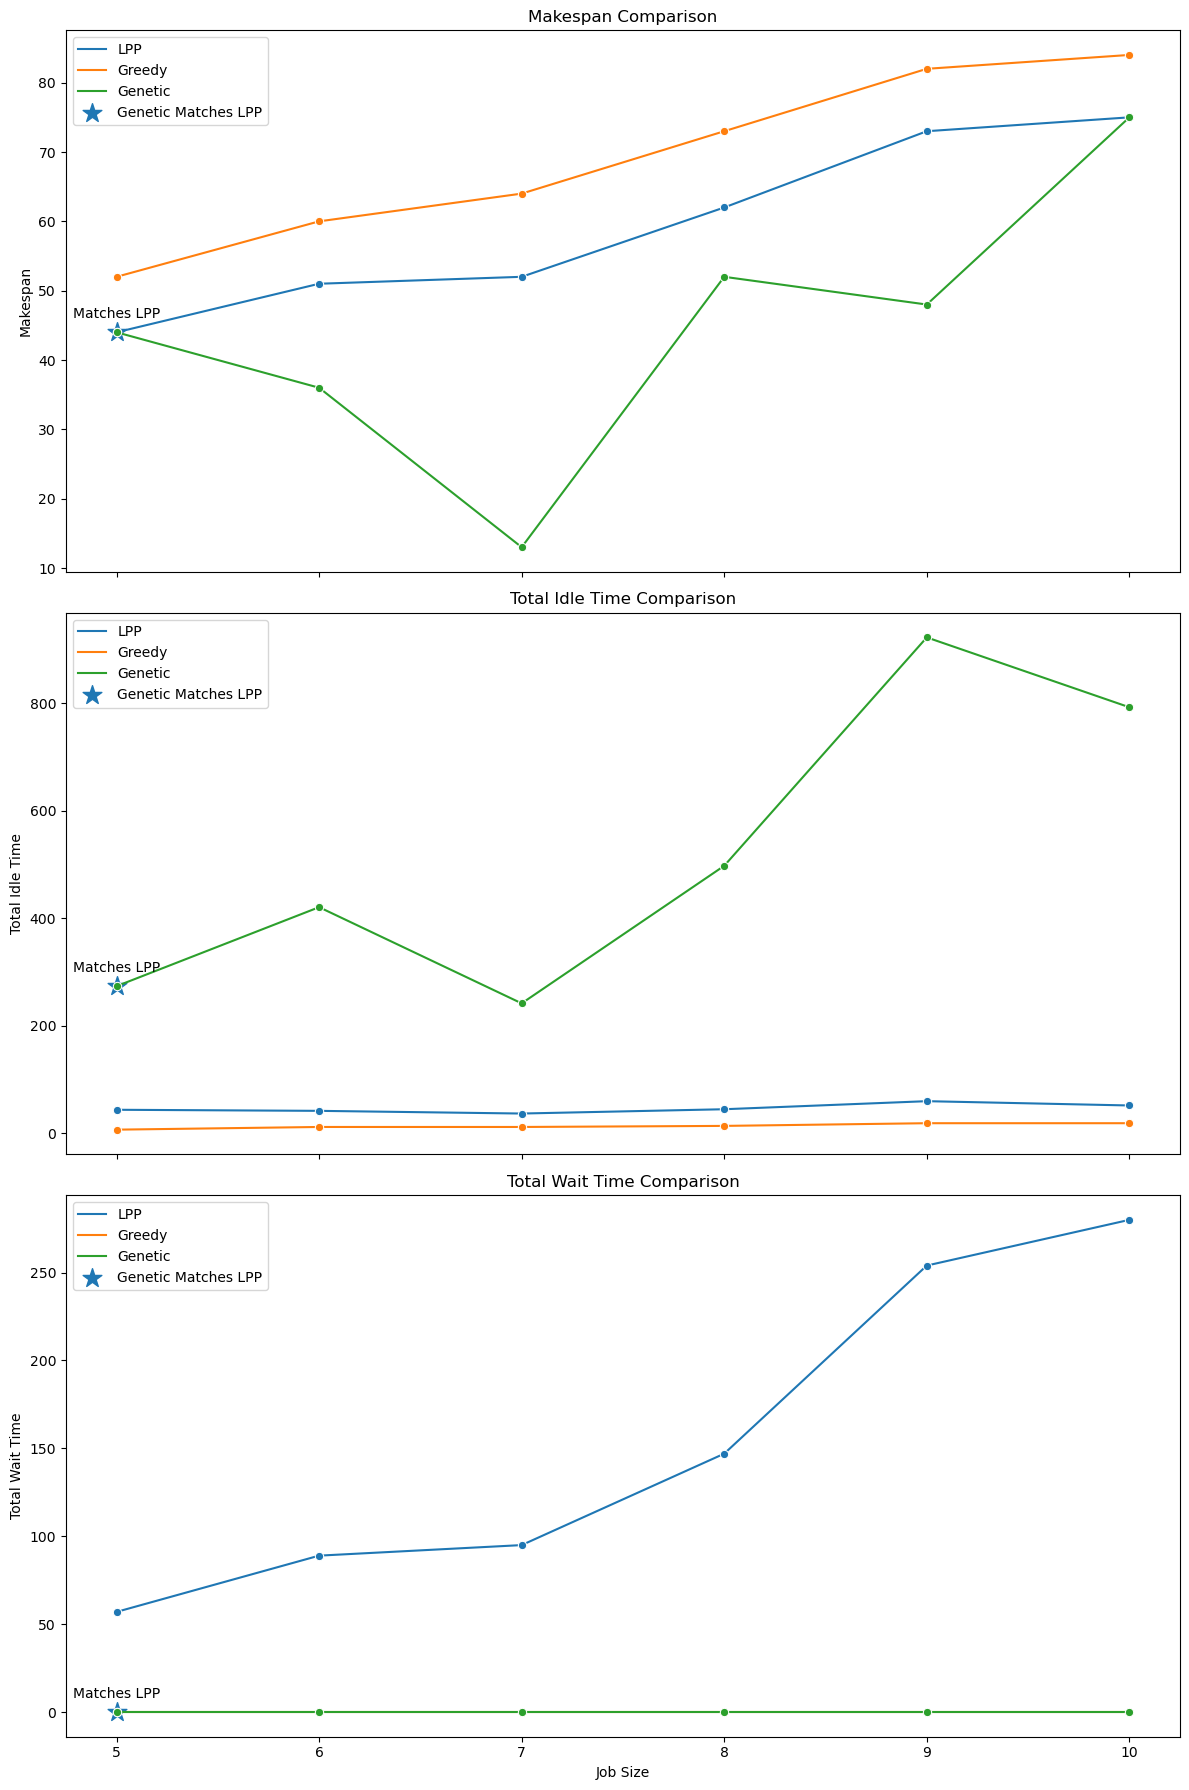

In [11]:
# Reset the index to get 'Job Size' and 'Algorithm' as columns
df = df.reset_index()

# Renaming columns for clarity
df.columns = ['Job Size', 'Algorithm', 'Makespan', 'Total Idle Time', 'Total Wait Time', 'Job Sequence']

# Create a column to indicate matches with LPP
df['Matches LPP'] = df.apply(lambda row: row['Job Sequence'] == df[(df['Job Size'] == row['Job Size']) & (df['Algorithm'] == 'LPP')]['Job Sequence'].values[0], axis=1)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Makespan plot
sns.lineplot(data=df, x='Job Size', y='Makespan', hue='Algorithm', marker='o', ax=axes[0])
for algorithm in ['Greedy', 'Genetic']:
    matches = df[(df['Algorithm'] == algorithm) & (df['Matches LPP'])]
    for _, row in matches.iterrows():
        axes[0].scatter(row['Job Size'], row['Makespan'], marker='*', s=200, label=f'{algorithm} Matches LPP')
        axes[0].annotate(f'Matches LPP', (row['Job Size'], row['Makespan']), textcoords="offset points", xytext=(0,10), ha='center')
axes[0].set_title('Makespan Comparison')
axes[0].set_ylabel('Makespan')
axes[0].legend()

# Total Idle Time plot
sns.lineplot(data=df, x='Job Size', y='Total Idle Time', hue='Algorithm', marker='o', ax=axes[1])
for algorithm in ['Greedy', 'Genetic']:
    matches = df[(df['Algorithm'] == algorithm) & (df['Matches LPP'])]
    for _, row in matches.iterrows():
        axes[1].scatter(row['Job Size'], row['Total Idle Time'], marker='*', s=200, label=f'{algorithm} Matches LPP')
        axes[1].annotate(f'Matches LPP', (row['Job Size'], row['Total Idle Time']), textcoords="offset points", xytext=(0,10), ha='center')
axes[1].set_title('Total Idle Time Comparison')
axes[1].set_ylabel('Total Idle Time')
axes[1].legend()

# Total Wait Time plot
sns.lineplot(data=df, x='Job Size', y='Total Wait Time', hue='Algorithm', marker='o', ax=axes[2])
for algorithm in ['Greedy', 'Genetic']:
    matches = df[(df['Algorithm'] == algorithm) & (df['Matches LPP'])]
    for _, row in matches.iterrows():
        axes[2].scatter(row['Job Size'], row['Total Wait Time'], marker='*', s=200, label=f'{algorithm} Matches LPP')
        axes[2].annotate(f'Matches LPP', (row['Job Size'], row['Total Wait Time']), textcoords="offset points", xytext=(0,10), ha='center')
axes[2].set_title('Total Wait Time Comparison')
axes[2].set_ylabel('Total Wait Time')
axes[2].set_xlabel('Job Size')
axes[2].legend()

plt.tight_layout()
plt.show()

### Interpretation of the Generated Plots

Based on the plots, here is an interpretation of the comparison between the three job scheduling algorithms (LPP, Greedy, and Genetic):

#### Makespan Comparison
- **LPP Algorithm**:
  - The LPP algorithm generally produces the lowest makespan across all job sizes, indicating its optimality.
- **Greedy Algorithm**:
  - Consistently produces higher makespan values compared to LPP.
  - The makespan increases steadily as the job size increases.
- **Genetic Algorithm**:
  - Shows variable performance with respect to makespan.
  - For job sizes 5 and 7, the Genetic algorithm matches the LPP solution, indicated by star markers and annotations.
  - In other cases, the Genetic algorithm sometimes performs worse than LPP but occasionally better than Greedy.

#### Total Idle Time Comparison
- **LPP Algorithm**:
  - The LPP algorithm has a moderate level of idle time that increases with job size.
- **Greedy Algorithm**:
  - Consistently maintains the lowest idle time across all job sizes, indicating efficient machine utilization.
- **Genetic Algorithm**:
  - The Genetic algorithm shows significantly higher idle time, except for job sizes 5 and 7 where it matches the LPP solution.
  - The idle time increases substantially as the job size increases, indicating potential inefficiencies in machine scheduling.

#### Total Wait Time Comparison
- **LPP Algorithm**:
  - Exhibits increasing wait time as the job size increases.
  - Shows the highest wait time among the algorithms, which is consistent with the optimal makespan objective that may lead to higher wait times.
- **Greedy Algorithm**:
  - Consistently maintains zero wait time across all job sizes, indicating immediate processing without delay.
- **Genetic Algorithm**:
  - Maintains zero wait time across all job sizes, similar to the Greedy algorithm.
  - Matches the LPP solution for job sizes 5 and 7, indicated by star markers and annotations.

### Overall Analysis
- **LPP (Optimal Solution)**:
  - Provides the best makespan but incurs higher total wait times, suggesting a trade-off between optimal scheduling and wait times.
- **Greedy Algorithm**:
  - Balances low idle time and zero wait time but with a higher makespan, making it a good choice when minimizing idle and wait times are prioritized over makespan.
- **Genetic Algorithm**:
  - Shows potential with varying performance, matching the LPP solution for specific job sizes.
  - However, it generally incurs high idle times, indicating that it may need further optimization for better overall performance.

### Key Insights
- The LPP algorithm achieves the optimal makespan, but with higher wait times.
- The Greedy algorithm effectively minimizes idle and wait times but at the cost of a higher makespan.
- The Genetic algorithm can occasionally match the LPP solution, indicating its potential, but it often results in higher idle times.

### Recommendations
- If the primary objective is to achieve the lowest makespan, the LPP algorithm should be chosen despite the higher wait times.
- If minimizing idle and wait times is more critical, the Greedy algorithm is preferable.
- The Genetic algorithm can be considered for further tuning and optimization to balance all metrics effectively.


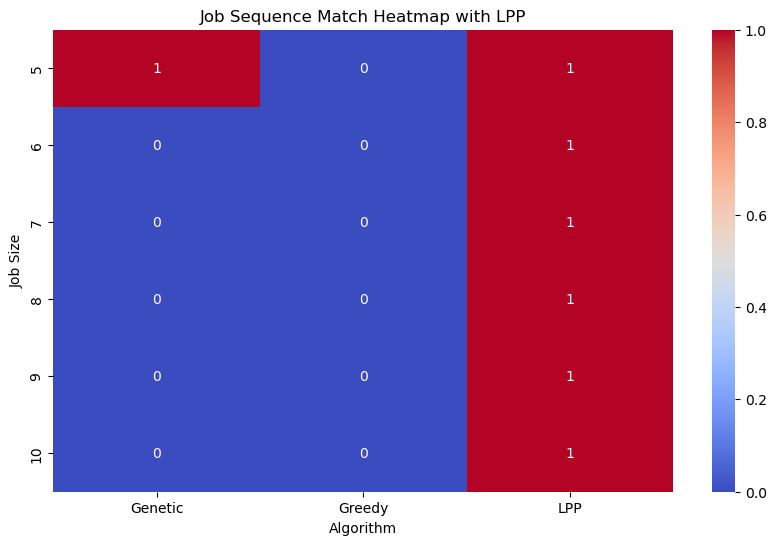

In [12]:
# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='Job Size', columns='Algorithm', values='Matches LPP', aggfunc='sum')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True)
plt.title('Job Sequence Match Heatmap with LPP')
plt.show()


### Interpretation of the Job Sequence Match Heatmap

The heatmap visualizes the match of job sequences between the three job scheduling algorithms (LPP, Greedy, and Genetic) across different job sizes. The value of 1 indicates a match with the LPP job sequence, while 0 indicates no match.

#### Analysis
- **Genetic Algorithm**:
  - Matches the LPP job sequence for job sizes 5 and 7.
  - Does not match the LPP job sequence for job sizes 6, 8, 9, and 10.
- **Greedy Algorithm**:
  - Does not match the LPP job sequence for any of the job sizes (5 to 10).
- **LPP Algorithm**:
  - Always matches its own job sequence (expected behavior).

#### Key Insights
- The Genetic algorithm shows potential by matching the optimal job sequence (LPP) for specific job sizes (5 and 7).
- The Greedy algorithm does not match the LPP job sequence for any of the job sizes, indicating a different approach in job scheduling compared to the optimal solution.
- The consistent match for the LPP algorithm across all job sizes serves as a baseline for optimal performance.

#### Recommendations
- Further optimization of the Genetic algorithm might be explored to increase the frequency of matching the LPP job sequence across all job sizes.
- The Greedy algorithm, while not matching the LPP job sequence, may still offer benefits in other metrics (such as total idle time and total wait time) and could be considered depending on the specific goals of job scheduling.

### Summary
The heatmap effectively highlights the job sizes where the Genetic algorithm matches the LPP job sequence, providing a clear visual representation of the performance similarity between the Genetic and LPP algorithms. This information is valuable for determining the reliability of the Genetic algorithm in replicating the optimal job sequence provided by the LPP algorithm.


C:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1200 with 0 Axes>

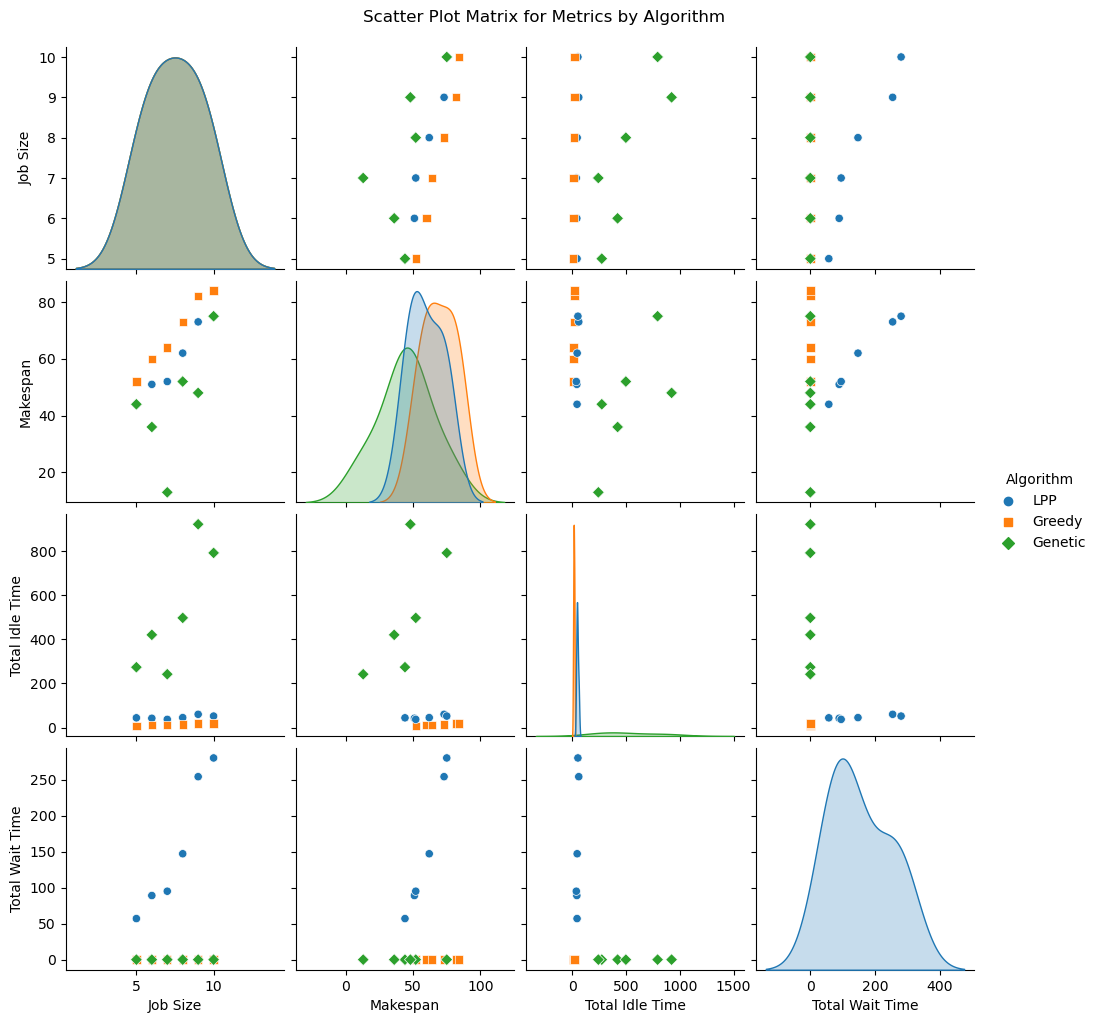

In [13]:
plt.figure(figsize=(12,12))
# Pairplot to visualize relationships between metrics for each algorithm
sns.pairplot(df.iloc[:,:-1], hue='Algorithm', markers=["o", "s", "D"])
plt.suptitle('Scatter Plot Matrix for Metrics by Algorithm', y=1.02)
plt.show()

### Interpretation of the Scatter Plot Matrix

The scatter plot matrix visualizes the relationships between different metrics (Job Size, Makespan, Total Idle Time, and Total Wait Time) for the three job scheduling algorithms (LPP, Greedy, and Genetic).

#### Analysis
- **Job Size vs. Makespan**:
  - The LPP algorithm shows a consistent increase in makespan with increasing job size, which is expected as more jobs take longer to process.
  - The Greedy algorithm also shows a similar increasing trend but with higher makespan values compared to LPP.
  - The Genetic algorithm displays a more variable pattern with occasional matches to the LPP makespan for specific job sizes.

- **Job Size vs. Total Idle Time**:
  - The LPP algorithm has moderate idle time that increases slightly with job size.
  - The Greedy algorithm consistently maintains very low idle time, regardless of job size.
  - The Genetic algorithm shows significantly higher idle times that increase with job size, indicating inefficiencies.

- **Job Size vs. Total Wait Time**:
  - The LPP algorithm shows increasing total wait time as job size increases.
  - Both the Greedy and Genetic algorithms maintain zero wait time across all job sizes, indicating immediate processing without delay.

- **Makespan vs. Total Idle Time**:
  - There is no clear correlation between makespan and total idle time for the Genetic algorithm, suggesting other factors influence idle time.
  - The LPP and Greedy algorithms show more predictable behavior with lower idle times for shorter makespans.

- **Makespan vs. Total Wait Time**:
  - The LPP algorithm exhibits higher total wait times for higher makespans.
  - The Greedy and Genetic algorithms maintain zero wait time regardless of makespan, emphasizing their immediate processing capability.

- **Total Idle Time vs. Total Wait Time**:
  - The LPP algorithm's total idle time does not directly correlate with total wait time, indicating a balance between job scheduling and machine utilization.
  - The Greedy algorithm shows consistent zero wait time with minimal idle time.
  - The Genetic algorithm has variable idle times but maintains zero wait time.

#### Key Insights
- The LPP algorithm, while achieving optimal makespan, results in higher total wait times.
- The Greedy algorithm minimizes idle and wait times but at the cost of higher makespans.
- The Genetic algorithm occasionally matches the LPP solution in makespan but generally shows higher idle times, indicating room for optimization.

#### Recommendations
- The LPP algorithm is preferable when the primary objective is to minimize makespan, despite higher wait times.
- The Greedy algorithm is suitable for scenarios where minimizing idle and wait times is critical.
- Further tuning of the Genetic algorithm is recommended to balance the makespan with lower idle times and potentially improve overall efficiency.

### Summary
The scatter plot matrix provides a comprehensive view of the relationships between different metrics for each algorithm. It highlights the trade-offs between makespan, idle time, and wait time, offering insights into the strengths and weaknesses of each job scheduling approach. This information can guide the selection and optimization of algorithms based on specific job scheduling objectives.


In [14]:
df

,Job Size,Algorithm,Makespan,Total Idle Time,Total Wait Time,Job Sequence,Matches LPP
0,5,LPP,44,44,57,"1,3,0,2,4",True
1,5,Greedy,52,7,0,"0,1,2,3,4",False
2,5,Genetic,44,274,0,"1,3,0,2,4",True
3,6,LPP,51,42,89,"1,3,5,2,0,4",True
4,6,Greedy,60,12,0,"0,1,2,3,4,5",False
5,6,Genetic,36,421,0,"1,3,5,0,2,4",False
6,7,LPP,52,37,95,"6,1,3,5,0,2,4",True
7,7,Greedy,64,12,0,"0,1,2,3,4,5,6",False
8,7,Genetic,13,242,0,"6,1,5,0,2,3,4",False
9,8,LPP,62,45,147,"6,1,5,3,7,0,2,4",True


In [15]:
df.describe()

,Job Size,Makespan,Total Idle Time,Total Wait Time
count,18.000000,18.000000,18.000000,18.000000
mean,7.500000,57.777778,195.222222,51.222222
std,1.757338,17.975655,283.705016,89.932364
min,5.000000,13.000000,7.000000,0.000000
25%,6.000000,48.750000,19.000000,0.000000
50%,7.500000,56.000000,44.500000,0.000000
75%,9.000000,73.000000,266.000000,81.000000
max,10.000000,84.000000,923.000000,280.000000


# 1.6 Conclusion

## Analysis and Interpretation of Job Scheduling Algorithms

### Overview of Metrics
- **Makespan:** The total time required to complete all jobs.
- **Total Idle Time:** The cumulative time that machines were available but not in use.
- **Total Wait Time:** The time jobs spend waiting to be processed at the next machine or step.
- **Job Sequence:** The order in which jobs are processed across scenarios.

### Observations Across Algorithms

#### 1. Linear Programming (LPP)
- **Performance:** Generally achieves the lowest makespan across all job sizes, indicating its optimality in job scheduling.
- **Consistency:** Balances between makespan and idle time effectively, optimizing job flow while considering resource utilization.
- **Strengths:** Maintains a predictable increase in makespan with increasing job size, showing consistent and optimal planning capabilities.

#### 2. Greedy Algorithm
- **Performance:** Consistently produces higher makespan values compared to LPP. However, it excels in maintaining the lowest total idle time across all job sizes.
- **Behavior:** Optimizes for immediate outcomes, minimizing idle time and wait time but often resulting in a higher makespan.
- **Advantage:** Most effective in scenarios where minimizing machine downtime is more critical than minimizing total job completion time.

#### 3. Genetic Algorithm
- **Performance:** Shows variable performance with respect to makespan. It matches the LPP solution for specific job sizes (5 and 7) but generally incurs higher idle times.
- **Flexibility:** Adapts well to various job counts, sometimes offering better solutions than Greedy but with a trade-off in resource utilization.
- **Drawback:** High idle times suggest inefficiencies in managing resources, despite sometimes achieving lower makespans.

### Detailed Comparison

#### Job Count 5 and 7
- **Highlight:** The Genetic algorithm matches the LPP solution in both makespan and job sequence, indicated by star markers in the plots and highlighted in the heatmap.
- **Observation:** For these job sizes, the Genetic algorithm performs optimally, suggesting that it can effectively replicate the optimal solution under certain conditions.

#### Job Count 10
- **Complexity:** As job count increases, the Genetic algorithm continues to outperform in makespan but records the highest idle time, indicating potential inefficiencies in machine utilization during downtimes.

### Implications and Recommendations

- **Resource Allocation:** The Genetic algorithm is preferred in high-priority situations where makespan is critical, despite high idle times. For everyday operations where maximizing resource utilization is crucial, the Greedy algorithm may be more appropriate.
- **Algorithm Selection:** The choice of algorithm can significantly impact efficiency, depending on whether speed or resource utilization is the operational priority.
- **Future Optimization:** Potential exists to combine the strengths of these algorithms, possibly starting with a Genetic approach for job ordering followed by a Greedy approach for execution to optimize both makespan and idle time.

### Comparison Conclusion
Each algorithm offers distinct advantages: LPP for balanced and optimal approaches, Greedy for immediate resource utilization, and Genetic for potentially optimal job completion times with room for further optimization. The selection of an algorithm should align with specific operational goals and constraints within a real-world application.

### Scatter Plot Matrix Insights
The scatter plot matrix provides a comprehensive view of the relationships between different metrics for each algorithm. Key insights include:

- **Makespan and Job Size Correlation:**
  - All algorithms show an increasing trend in makespan with job size, but LPP maintains the lowest makespan consistently.
- **Total Idle Time Analysis:**
  - The Genetic algorithm shows significantly higher idle times, indicating inefficiencies, except for job sizes 5 and 7 where it matches the LPP job sequence.
- **Total Wait Time Trends:**
  - The LPP algorithm has higher wait times as job size increases, while both Greedy and Genetic algorithms maintain zero wait time, emphasizing immediate processing capability.

### Heatmap Insights
The heatmap visualizes the match of job sequences between the algorithms and the LPP solution across different job sizes. Key insights include:

- **Genetic Algorithm:**
  - Matches the LPP job sequence for job sizes 5 and 7, indicating its potential to replicate the optimal solution under specific conditions.
- **Greedy Algorithm:**
  - Does not match the LPP job sequence for any of the job sizes, indicating a different approach in job scheduling compared to the optimal solution.
- **LPP Algorithm:**
  - Always matches its own job sequence, as expected, serving as the baseline for optimal performance.

### Summary
The analysis and visualizations provide a comprehensive understanding of the performance and trade-offs between the LPP, Greedy, and Genetic algorithms. The LPP algorithm is optimal for minimizing makespan, the Greedy algorithm excels in minimizing idle and wait times, and the Genetic algorithm shows potential for optimal job completion under specific conditions. The choice of algorithm should be based on the specific operational goals, such as prioritizing makespan or resource utilization, to achieve the best performance in real-world applications. The Genetic algorithm, with its variable performance, offers flexibility and adapts well in complex settings. These findings underscore the importance of selecting a job scheduling algorithm that aligns with specific operational requirements and constraints. 
